In [1]:
#30k datasets 

import numpy as np
from Bio import SeqIO
import gzip
import os
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D, Dropout
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import pickle

np.random.seed(454)


def load_data(path):
        
    data = gzip.open(os.path.join(path,"sequences.fa.gz"),"rt")
    return data


def get_seq(protein, t_data, training_set_number):
    if t_data == "train":         
        training_data = load_data("datasets/clip/%s/30000/training_sample_%s"% (protein, training_set_number))
        x_train = np.zeros((30000,101,4))          
    elif t_data == "test":    
        training_data = load_data("datasets/clip/%s/30000/test_sample_%s"% (protein, training_set_number))
        x_train = np.zeros((10000,101,4))   
    r = 0    
    for record in SeqIO.parse(training_data,"fasta"):
        sequence = list(record.seq)                
        nucleotide = {'A' : 0, 'T' : 1, 'G' : 2, 'C' : 3, 'N' : 4} 
        num_seq = list() #sekvenca v številskem formatu
        for i in range(0,len(sequence)):
                num_seq.append(nucleotide[sequence[i]])
        X = np.zeros((1,len(num_seq),4))
        for i in range (len(num_seq)):
                if num_seq[i] <= 3:
                    X[:,i,num_seq[i]] = 1               
        x_train[r,:,:] = X
        r = r + 1
    return x_train


def get_class(protein, t_data,training_set_number):
    y_train = []
    if t_data == 'train':
        data = load_data("datasets/clip/%s/30000/training_sample_%s"% (protein, training_set_number))
    elif t_data == 'test':
        data = load_data("datasets/clip/%s/30000/test_sample_%s"% (protein, training_set_number))
    for record in SeqIO.parse(data,"fasta"):
        v = int((record.description).split(":")[1])
        y_train.append([int(v == 0), int(v != 0)])
    y_train = np.array(y_train)
    return y_train


def get_cobinding(protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_Cobinding.tab.gz"% (protein, training_set_number)), "rt") as f:
            cobinding_data = np.loadtxt(f, skiprows=1)       
        cobinding = np.zeros((30000,101,cobinding_data.shape[1]/101),dtype=np.int)    
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_Cobinding.tab.gz"% (protein, training_set_number)), "rt") as f:
            cobinding_data = np.loadtxt(f, skiprows=1) 
        cobinding = np.zeros((10000,101,cobinding_data.shape[1]/101),dtype=np.int)
    for n in range(0,cobinding_data.shape[1],101):
        a = cobinding_data[:,n:(n+101)]
        cobinding[:,:,(n/101)] = a
    return cobinding
    

def get_region (protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_RegionType.tab.gz"% (protein, training_set_number)), "rt") as f:
            region_data = np.loadtxt(f, skiprows=1)
        region = np.zeros((30000,101,region_data.shape[1]/101),dtype=np.int)
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_RegionType.tab.gz"% (protein, training_set_number)), "rt") as f:
            region_data = np.loadtxt(f, skiprows=1) 
        region = np.zeros((10000,101,region_data.shape[1]/101),dtype=np.int)
    for n in range(0,region_data.shape[1],101):
        a = region_data[:,n:(n+101)]
        region[:,:,(n/101)] = a
        
    return region


def get_fold (protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_RNAfold.tab.gz"% (protein, training_set_number)), "rt") as f:
            fold_data = np.loadtxt(f, skiprows=1) 
        fold = np.zeros((30000,101,fold_data.shape[1]/101),dtype=np.int)
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_RNAfold.tab.gz"% (protein, training_set_number)), "rt") as f:
            fold_data = np.loadtxt(f, skiprows=1) 
        fold = np.zeros((10000,101,fold_data.shape[1]/101),dtype=np.int)
    for n in range(0,fold_data.shape[1],101):
        a = fold_data[:,n:(n+101)]
        fold[:,:,(n/101)] = a
    return fold

def load_data_sources(protein, t_data, training_set_number, *args):
    X = np.array([])
    data_sources = []
    for arg in args:
        
        if arg == 'KMER':
            if X.size == 0:
                X = get_seq(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_seq(protein, t_data, training_set_number)))
        if arg == 'RNA': 
            if X.size == 0:
                X = get_fold(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_fold(protein, t_data, training_set_number)))
        if arg == 'RG':   
            if X.size == 0:
                X = get_region(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_region(protein, t_data, training_set_number)))
        if arg == 'CLIP': 
            if X.size == 0:
                X = get_cobinding(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_cobinding(protein, t_data, training_set_number)))
        data_sources.append(arg)
    data_sources = ' '.join(data_sources)     
    return data_sources, X


protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
table_data = {}
dataset_list = ['KMER', 'RNA', 'RG', 'CLIP']
training_set_number = 0

# We have to generate combinations with differnet lengths, thus we generate length intigers and create sets with all combinations at given length.
for length in range(1,5):
    for set in itertools.combinations(dataset_list, length):

        average_score = np.zeros(len(protein_list))
        score_list = []

        for protein in protein_list:
           
            data_sources, X = load_data_sources(protein, 'train', training_set_number, *set)
            y = get_class(protein,"train",training_set_number)
            size = X.shape[2]
            score = []

            model = Sequential()
            model.add(Conv1D(10,6, data_format='channels_last', input_shape=(101, size) , strides = 1, padding='valid'))
            model.add(MaxPooling1D(pool_size=20, strides=1, padding='valid'))
            model.add(Conv1D(10, 4, activation='relu'))
            model.add(Dropout(0.1))
            model.add(MaxPooling1D(pool_size=40, strides=1, padding='valid'))
            model.add(Conv1D(15, 4, activation='relu'))
            model.add(MaxPooling1D(pool_size=30, strides=1, padding='valid'))
            model.add(Conv1D(15, 3, activation='relu'))
            model.add(GlobalAveragePooling1D())
            model.add(Dense(200, activation='relu'))
            model.add(Dropout(0.1))
            model.add(Dense(2, activation='softmax'))

            model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

            checkpointer = ModelCheckpoint(filepath="models/" + protein + "_weights.hdf5", verbose=0, save_best_only=True)
            earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=0)

            X_train = X
            y_train = y

            metrics = model.fit(X_train, y_train, validation_split = 0.2, epochs=12, batch_size=200, verbose=0, callbacks=[earlystopper])

            #Run predictions on test dataset.
            data_sources, X_test = load_data_sources(protein, 'test', 0, *set)
            y_test = get_class(protein,"test",training_set_number)


            y_scores = model.predict(X_test)
            y_scores = y_scores [:,0:1]
            y_test = y_test [:,0:1]
            score = roc_auc_score(y_test, y_scores)            
            score_list.append(score)
        
        print (protein)
        table_data[data_sources] = score_list
        
#         with open('auc_combinations_results.pickle', 'wb') as f:
#             pickle.dump(table_data, f, protocol=pickle.HIGHEST_PROTOCOL)            

Using TensorFlow backend.
/home/alovse/miniconda3/envs/rnap3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alovse/miniconda3/envs/rnap3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/alovse/miniconda3/envs/rnap3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/alovse/minicon

KeyboardInterrupt: 

In [1]:
import pickle
import numpy as np
import pandas as pd

def highlight_max(s):
    is_max = s == max(s)
    return ['background-color: yellow' if v else '' for v in is_max]


protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]

with open('auc_combinations_results.pickle', 'rb') as f:
    loaded_table_data = pickle.load(f)

for dict_value in loaded_table_data:
    loaded_table_data[dict_value] = np.round(np.array(loaded_table_data[dict_value]),3)

loaded_table = pd.DataFrame(loaded_table_data, index = [i+1 for i in range (len(protein_list))])
loaded_table = loaded_table.T
loaded_table = loaded_table.reindex(sorted(loaded_table.columns), axis=1)

loaded_table.style.apply(highlight_max)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
CLIP,0.862,0.728,0.745,0.75,0.727,0.8,0.77,0.823,0.737,0.938,0.939,0.851,0.664,0.95,0.872,0.614,0.646,0.801,0.675,0.726,0.928,0.72,0.87,0.623,0.75,0.887,0.533,0.889,0.832,0.675,0.686
KMER,0.705,0.578,0.804,0.825,0.618,0.931,0.934,0.918,0.562,0.886,0.882,0.907,0.936,0.949,0.677,0.953,0.97,0.698,0.705,0.656,0.799,0.764,0.953,0.96,0.858,0.955,0.905,0.915,0.874,0.928,0.911
KMER CLIP,0.9,0.743,0.877,0.884,0.757,0.943,0.948,0.965,0.749,0.954,0.952,0.96,0.946,0.988,0.908,0.957,0.973,0.849,0.791,0.781,0.96,0.862,0.984,0.974,0.898,0.98,0.915,0.966,0.936,0.942,0.926
KMER RG,0.885,0.662,0.925,0.918,0.678,0.948,0.96,0.951,0.662,0.923,0.921,0.931,0.933,0.976,0.914,0.954,0.969,0.797,0.754,0.738,0.953,0.833,0.974,0.968,0.896,0.96,0.91,0.954,0.916,0.931,0.929
KMER RG CLIP,0.934,0.748,0.931,0.933,0.758,0.955,0.968,0.968,0.768,0.951,0.946,0.96,0.948,0.992,0.956,0.961,0.973,0.854,0.793,0.784,0.976,0.861,0.989,0.979,0.919,0.982,0.919,0.97,0.951,0.948,0.94
KMER RNA,0.765,0.571,0.823,0.837,0.629,0.936,0.947,0.93,0.594,0.893,0.89,0.911,0.936,0.954,0.752,0.951,0.969,0.707,0.713,0.661,0.861,0.797,0.958,0.964,0.869,0.956,0.916,0.916,0.875,0.922,0.924
KMER RNA CLIP,0.905,0.76,0.888,0.89,0.762,0.94,0.959,0.963,0.743,0.948,0.956,0.959,0.944,0.99,0.917,0.959,0.972,0.853,0.789,0.777,0.961,0.857,0.986,0.976,0.894,0.985,0.92,0.965,0.937,0.928,0.923
KMER RNA RG,0.896,0.679,0.931,0.927,0.685,0.958,0.976,0.954,0.696,0.928,0.923,0.937,0.936,0.975,0.924,0.954,0.969,0.806,0.744,0.754,0.956,0.84,0.979,0.972,0.914,0.962,0.911,0.954,0.918,0.931,0.931
KMER RNA RG CLIP,0.933,0.748,0.939,0.94,0.764,0.957,0.978,0.969,0.755,0.944,0.94,0.961,0.944,0.991,0.958,0.958,0.972,0.854,0.79,0.79,0.979,0.866,0.99,0.978,0.919,0.981,0.919,0.974,0.943,0.944,0.941
RG,0.854,0.646,0.848,0.84,0.608,0.885,0.902,0.739,0.678,0.878,0.878,0.726,0.583,0.867,0.891,0.632,0.613,0.734,0.63,0.694,0.916,0.765,0.884,0.578,0.84,0.7,0.635,0.827,0.778,0.699,0.673


In [3]:
import os
import dill
import pickle
import argparse


def convert(old_pkl):
    """
    Convert a Python 2 pickle to Python 3
    """
    # Make a name for the new pickle
    new_pkl = os.path.splitext(os.path.basename(old_pkl))[0]+"_p3.pkl"

    # Convert Python 2 "ObjectType" to Python 3 object
    dill._dill._reverse_typemap["ObjectType"] = object

    # Open the pickle using latin1 encoding
    with open(old_pkl, "rb") as f:
        loaded = pickle.load(f, encoding="latin1")

    # Re-save as Python 3 pickle
    with open(new_pkl, "wb") as outfile:
        pickle.dump(loaded, outfile)
convert('auc_combinations_results.pickle')

AUC for KMER RG is 0.89 ± 0.02
AUC for KMER RNA CLIP is 0.91 ± 0.01
AUC for KMER RNA is 0.85 ± 0.02
AUC for CLIP is 0.77 ± 0.02
AUC for RNA RG is 0.77 ± 0.02
AUC for RNA is 0.59 ± 0.01
AUC for KMER RG CLIP is 0.92 ± 0.01
AUC for RNA CLIP is 0.8 ± 0.02
AUC for RG is 0.76 ± 0.02
AUC for KMER CLIP is 0.91 ± 0.01
AUC for KMER is 0.84 ± 0.02
AUC for KMER RNA RG is 0.9 ± 0.02
AUC for KMER RNA RG CLIP is 0.92 ± 0.01
AUC for RG CLIP is 0.84 ± 0.02
AUC for RNA RG CLIP is 0.84 ± 0.02


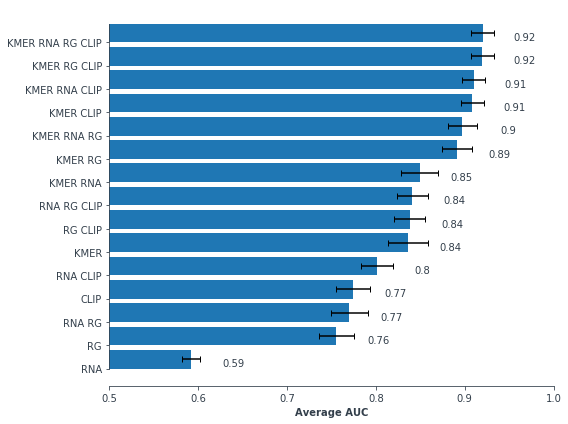

In [4]:
import pickle
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from collections import OrderedDict

plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

fig, ax = plt.subplots(figsize=(8,6))
source_sem = {}
with open('auc_combinations_results_p3.pkl', 'rb') as f:
    loaded_table_data = pickle.load(f)
    for source in loaded_table_data.keys():
        std = stats.sem(loaded_table_data[source])
        source_sem[source] = std
        loaded_table_data[source] = np.average(loaded_table_data[source])
        print(u'AUC for {} is {} \u00B1 {}'.format(source, np.round(loaded_table_data[source], 2), np.round(std, 2)))
        

    sorted_data = OrderedDict(sorted(loaded_table_data.items(), key=lambda x: x[1]))
    sorted_sem = [source_sem[source] for source in sorted_data.keys()]
    
    bars = ax.barh(list(sorted_data.keys()), list(sorted_data.values()), align='edge', xerr=sorted_sem, capsize=3)
    ax.set_xlim(0.5, 1)
    for bar in bars:
        ax.annotate(round(bar.get_width(), 2), xy=(bar.get_width() + bar.get_x() + 0.06, bar.get_y()),
                    xytext=(0, 0), textcoords="offset points", ha='right', va='bottom', color='#333F4B')
    
    ax.set_xlabel('Average AUC', fontweight='black', color = '#333F4B')
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_smart_bounds(True)
    ax.spines['bottom'].set_smart_bounds(True)
    plt.tight_layout()
    plt.savefig("figures/averages_data_sources.png")
    plt.show()
    
    #plot distribution, or show percentile error, boxplot

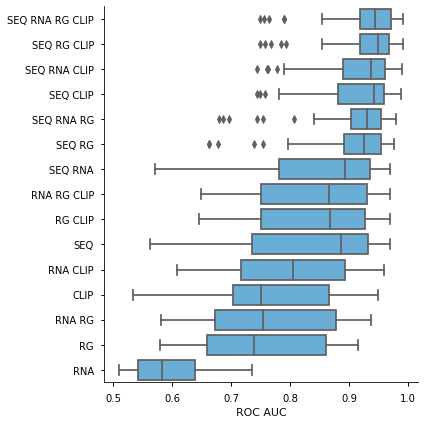

In [69]:
import pandas as pd
import seaborn as sns
from collections import OrderedDict
import matplotlib.style as style

style.use('seaborn-notebook')


with open('auc_combinations_results_p3.pkl', 'rb') as f:
    table_data = pickle.load(f)
    table_data = { key.replace("KMER", "SEQ") : value for key, value in table_data.items() }
    
loaded_table_data = {}
for source in table_data.keys():
    loaded_table_data[source] = np.average(table_data[source])

sorted_data = OrderedDict(sorted(loaded_table_data.items(), key=lambda x: x[1]))

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlabel('ROC AUC', color = '#0A0C0F')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
df = pd.DataFrame.from_dict(table_data)
box = sns.boxplot(data=df, orient="h", order=list(sorted_data.keys())[::-1], palette=sns.color_palette("Blues", n_colors=1), ax=ax, saturation=1)
plt.tight_layout()
plt.savefig("figures/box_averages_data_sources.pdf")

In [57]:
sns.color_palette("Blues", n_colors=4)

[(0.8141176470588235, 0.883921568627451, 0.9498039215686275),
 (0.5796078431372549, 0.7701960784313725, 0.8737254901960784),
 (0.2909803921568628, 0.5945098039215686, 0.7890196078431373),
 (0.09019607843137256, 0.39294117647058824, 0.6705882352941177)]

[1.0, 0.26339571991500094, 0.09422287602690334, 0.017933100298118294]
[0.26339571991500094, 0.9999999999999998, 0.8604694671604259, 0.5306063985739145]
[0.09422287602690334, 0.8604694671604259, 1.0, 0.7555004525386361]
[0.017933100298118294, 0.5306063985739145, 0.7555004525386361, 1.0]


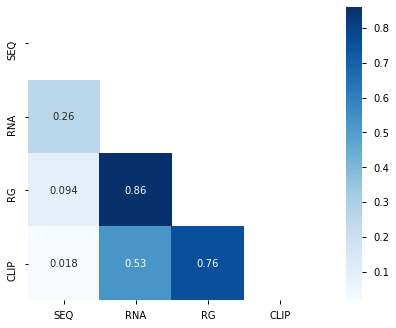

In [71]:
import pickle
import numpy as np
from scipy import stats
from scipy.stats.stats import pearsonr  
import pandas as pd
import itertools
import seaborn as sns

with open('auc_combinations_results_p3.pkl', 'rb') as f:
    loaded_table_data = pickle.load(f)
    loaded_table_data = { key.replace("KMER", "SEQ") : value for key, value in table_data.items() }


    index = ['SEQ' , 'RNA', 'RG', 'CLIP']
    df = pd.DataFrame(index = index)

    for source in index:
        correlation = [(pearsonr(loaded_table_data[source],loaded_table_data[s]))[0] for s in index]
        print(correlation)
        df1 = pd.DataFrame(correlation, index = index, columns =  [source])
        df = df.join(df1)
    # print(df)

    grid_kws = {"width_ratios": (.9, .05)}
    fig, (ax, cbar_ax) = plt.subplots(nrows=1, ncols=2, figsize=(6, 5.4), gridspec_kw=grid_kws)
    mask = np.zeros_like(df)
    mask[np.triu_indices_from(mask)] = True
    ax = sns.heatmap(df, cmap=sns.color_palette("Blues", as_cmap=True), annot=True, mask=mask, ax=ax, cbar_ax=cbar_ax)
    plt.savefig("figures/data_sources_correlation_mask.pdf", pad_inches=0)


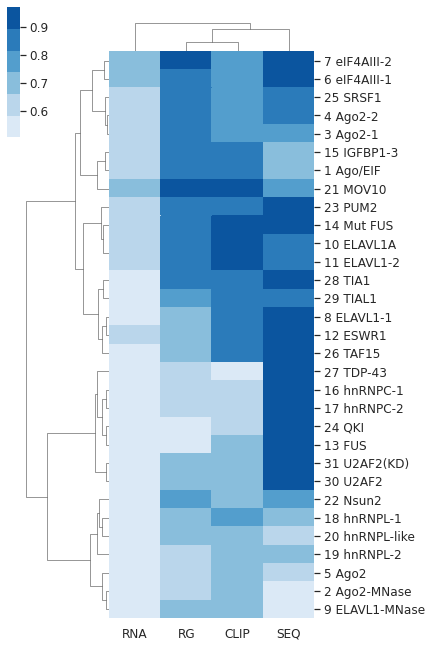

In [39]:
import seaborn as sns
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram

individual_sources = np.zeros((4,31))
protein_names = ['1 Ago/EIF', '2 Ago2-MNase', '3 Ago2-1', '4 Ago2-2', '5 Ago2', '6 eIF4AIII-1', '7 eIF4AIII-2', '8 ELAVL1-1', '9 ELAVL1-MNase', '10 ELAVL1A', '11 ELAVL1-2', '12 ESWR1', '13 FUS', '14 Mut FUS', '15 IGFBP1-3', '16 hnRNPC-1', '17 hnRNPC-2', '18 hnRNPL-1', '19 hnRNPL-2', '20 hnRNPL-like', '21 MOV10', '22 Nsun2', '23 PUM2', '24 QKI', '25 SRSF1' , '26 TAF15', '27 TDP-43', '28 TIA1', '29 TIAL1', '30 U2AF2', '31 U2AF2(KD)']
with open('auc_combinations_results_p3.pkl', 'rb') as f:
    loaded_table_data = pickle.load(f)
    loaded_table_data = { key.replace("KMER", "SEQ") : value for key, value in loaded_table_data.items() }
individual_sources = {k:loaded_table_data[k] for k in ['SEQ' , 'RNA', 'RG', 'CLIP']}

data = pd.DataFrame(individual_sources).to_numpy()
row_linkage = linkage(data, method = 'ward', metric="euclidean", optimal_ordering=True)
col_linkage = linkage(data.T, method = 'ward', metric="euclidean", optimal_ordering=True)

sns.set(font_scale=1.1)

#     print(loaded_table_data)
g = sns.clustermap(
    data, 
    method = 'ward', 
    cmap = sns.color_palette("Blues"), 
    yticklabels=protein_names,
    xticklabels=['SEQ' , 'RNA', 'RG', 'CLIP'],
    row_linkage=row_linkage,
    col_linkage=col_linkage,
    figsize=(6,9),
    dendrogram_ratio=(0.3, 0.05),
    cbar_pos=(0, 0.8, .03, .2)
)
plt.savefig("figures/protein_cluster_data_sources.pdf", pad_inches=1)
